## gml-extent-maker

* Dataset
     * HI.x833.000.0009 - 2-meter Topographic Lidar Digital Elevation Model (DEM) of the Upper Texas Coast, 2015-02-02 to 2019-01-29
* Source data
     * shapefile polygon of DEM footprint, nodata cells not included


In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob, os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from osgeo import osr
#from osgeo import ogr
from tqdm import tqdm
from geopandas import GeoDataFrame
from shapely import geometry
#from shapely.geometry import box, mapping, Point, LineString, Polygon, MultiPoint, MultiPolygon
from shapely.geometry import Point
from geomEngine import *
from gmlEngine import get_rounded_geom, gmlReplacer, gmlMaker
from concave_hull import alpha_shape_vector

import inspect
output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [2]:
gdf = gpd.read_file('./data/EV_TOPO_UpperTexasCoastDEM_2m_HRI_2021.shp')
print(gdf.crs)
print(len_geom(gdf.geometry[0]))
gdf

epsg:26915
(10692, 'coords', 152, 'geoms', 'MultiPolygon')


,OID_,Shape_Leng,Shape_Area,geometry
0,0,4.099568e+06,1.634433e+10,MULTIPOLYGON Z (((397581.000 3379499.000 14.27...


<AxesSubplot:>

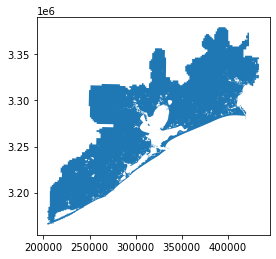

In [3]:
gdf.plot()

In [4]:
%%time
simp_gdf = gdf.copy()
simp_gdf['geometry'] = gdf.geometry.simplify(100)
print(len_geom(simp_gdf.geometry[0]))

(2568, 'coords', 152, 'geoms', 'MultiPolygon')
Wall time: 78 ms


<AxesSubplot:>

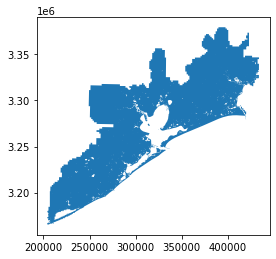

In [5]:
simp_gdf.plot()

EPSG:4326


<AxesSubplot:>

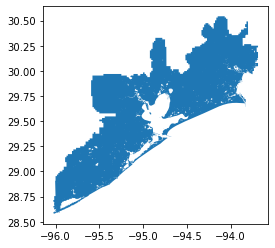

In [6]:
simp_gdf_wgs84 = simp_gdf.to_crs("EPSG:4326")
print(simp_gdf_wgs84.crs)
simp_gdf_wgs84.plot()

In [7]:
# Get all coords into pointList to feed to concave hull
g = simp_gdf_wgs84.geometry[0]
pointList = []
for poly in tqdm(g.geoms):
    for pt in poly.exterior.coords:
        x = pt[0]
        y = pt[1]
        newPoint = Point(x,y)
        pointList.append(newPoint)
print(len(pointList))
print(pointList[0])

100%|██████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 9482.60it/s]

2568
POINT (-94.06774896305559 30.54351741640801)


(124, 'coords', 1, 'geoms', 'Polygon')


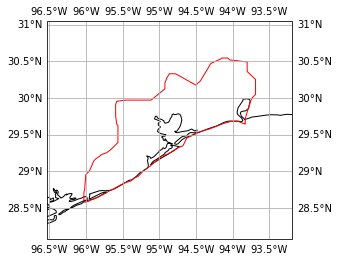

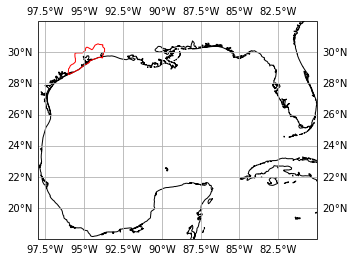

Wall time: 789 ms


In [8]:
%%time
# Concave Hull

alpha = 6
concave_hull, edge_points = alpha_shape_vector(pointList, alpha=alpha)
print(len_geom(concave_hull))
plot_geoms(concave_hull)

In [11]:
newgml = gmlMaker(get_rounded_geom(concave_hull))
gmlReplacer(newgml,"extent-metadata.xml")